### Step 1: Imported all required TensorFlow and Keras modules for building and training the ResNet model.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


### Step 2: Loaded training and validation image datasets from the specified directories and resized them to 128x128.

In [19]:
batch_size = 32
img_size = (128, 128)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:/final_dataset/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "E:/final_dataset/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=False
)


Found 9469 files belonging to 7 classes.
Found 2810 files belonging to 7 classes.


### Step 3: Calculated and printed the number of emotion classes from the training dataset.

In [20]:
num_classes = len(train_ds.class_names)
print(f"Number of classes: {num_classes}")


Number of classes: 7


### Step 4: Converted grayscale images to RGB and applied caching and prefetching for performance optimization.

In [4]:
def convert_grayscale_to_rgb(images, labels):
    if images.shape[-1] == 1:
        images = tf.image.grayscale_to_rgb(images)
    return images, labels

train_ds = train_ds.map(convert_grayscale_to_rgb).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(convert_grayscale_to_rgb).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


### Step 5: Loaded the pre-trained ResNet50 model without the top layer and froze its weights for transfer learning.

In [5]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False  # Freeze base model for initial training


### Step 6: Built a custom model on top of ResNet50 by adding global pooling, dropout, and a dense classification head.

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


### Step 7: Compiled the model using Adam optimizer and sparse categorical crossentropy loss for multi-class classification.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # no label_smoothing
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Step 8: Defined callbacks for early stopping, learning rate reduction, and model checkpointing.

In [9]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_accuracy', save_best_only=True)

callbacks = [early_stop, reduce_lr, checkpoint]


### Step 9: Started training the model with the training and validation datasets using specified callbacks.

In [10]:
initial_epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks
)


Epoch 1/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step - accuracy: 0.3143 - loss: 2.0178 - val_accuracy: 0.5911 - val_loss: 1.0876 - learning_rate: 0.0010
Epoch 2/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.5251 - loss: 1.2436 - val_accuracy: 0.6224 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 3/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.5679 - loss: 1.1456 - val_accuracy: 0.6416 - val_loss: 0.9715 - learning_rate: 0.0010
Epoch 4/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.5904 - loss: 1.0899 - val_accuracy: 0.6388 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 5/5
296/296 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.5908 - loss: 1.0568 - val_accuracy: 0.6544 - val_loss: 0.9225 - learning_rate: 0.0010


### Step 10: Unfroze the ResNet50 base model layers for fine-tuning on our dataset.

In [11]:
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


### Step 11: Recompiled the model with a lower learning rate to safely update the previously frozen layers.

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Removed label_smoothing
    metrics=['accuracy']
)


### Step 12: Continued training the now fully trainable model with callbacks.

In [14]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)


Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1100s 4s/step - accuracy: 0.4549 - loss: 1.9601 - val_accuracy: 0.6359 - val_loss: 1.0021 - learning_rate: 1.0000e-05
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1030s 3s/step - accuracy: 0.6442 - loss: 0.9648 - val_accuracy: 0.6708 - val_loss: 0.9057 - learning_rate: 1.0000e-05
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1019s 3s/step - accuracy: 0.7522 - loss: 0.6563 - val_accuracy: 0.6943 - val_loss: 0.8738 - learning_rate: 1.0000e-05
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1107s 4s/step - accuracy: 0.8420 - loss: 0.4438 - val_accuracy: 0.7068 - val_loss: 0.8807 - learning_rate: 1.0000e-05
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1137s 4s/step - accuracy: 0.9125 - loss: 0.2960 - val_accuracy: 0.7139 - val_loss: 0.8950 - learning_rate: 1.0000e-05
Epoch 10/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 1247s 4s/step - accuracy: 0.9549 - loss: 0.1860 - val_accuracy: 0.7157 - val_loss: 0.9290 - learning_rate: 5.0000e-06


### Step 13: Evaluated the final model on the validation dataset.

In [15]:
val_acc = history_fine.history['val_accuracy'][-1]
train_acc = history_fine.history['accuracy'][-1]
print(f" Final Validation Accuracy: {val_acc:.4f}")
print(f" Final Training Accuracy: {train_acc:.4f}")


 Final Validation Accuracy: 0.7157
 Final Training Accuracy: 0.9594


### Step 14: Plot Training and Validation Accuracy and Loss Curves After Fine-Tuning


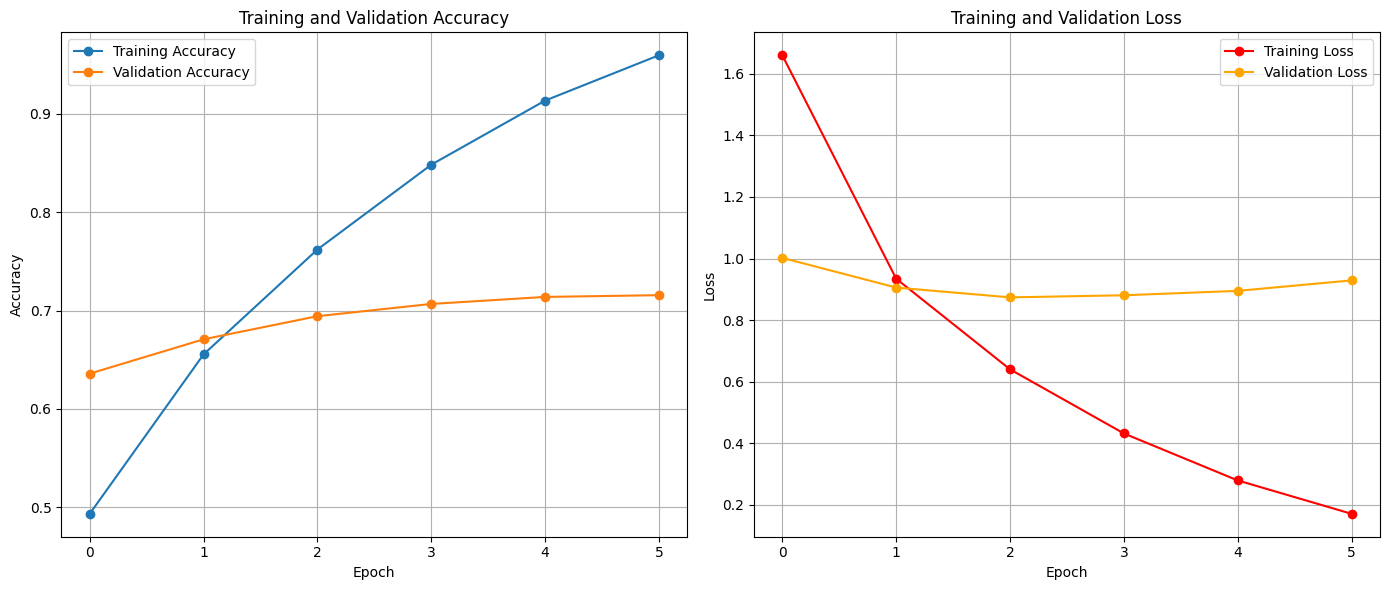

In [16]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from fine-tuning history
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
epochs_range = range(len(acc))

# Create plots
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Step 15: Generate Classification Report and Plot Confusion Matrix


88/88 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.79      0.80      0.79       466
     disgust       0.70      0.65      0.67       469
        fear       0.65      0.67      0.66       468
       happy       0.72      0.71      0.71       471
     neutral       0.72      0.75      0.74       401
         sad       0.69      0.70      0.69       466
   surprised       0.89      0.96      0.92        69

    accuracy                           0.72      2810
   macro avg       0.74      0.75      0.74      2810
weighted avg       0.72      0.72      0.72      2810



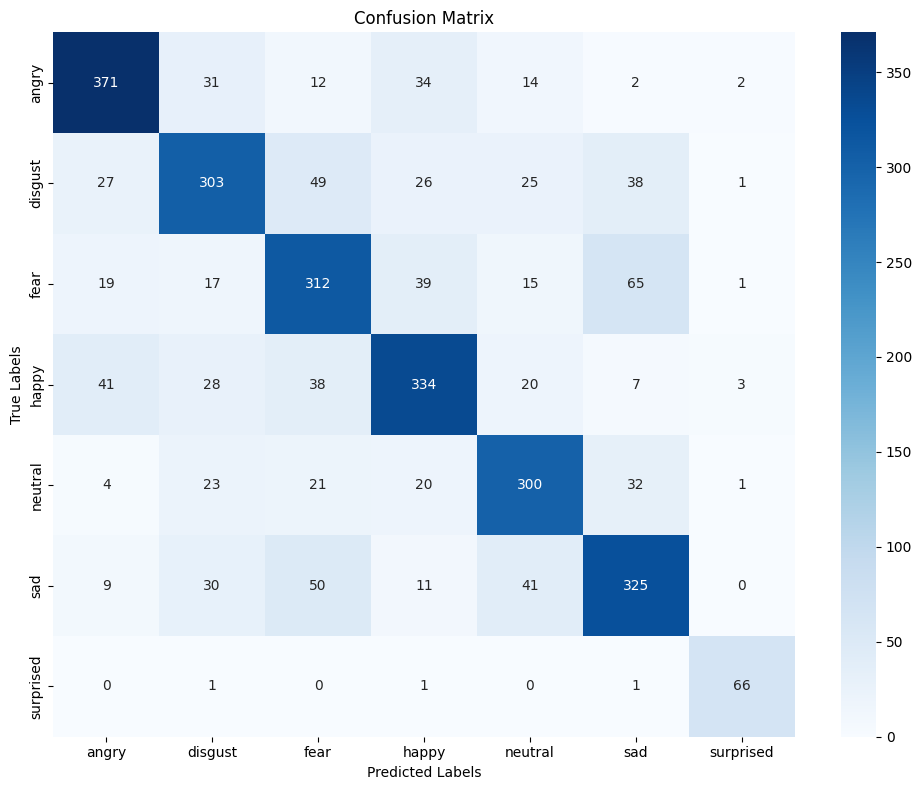

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predicted labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class names from dataset
class_names = list(val_ds.class_names)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


### Step 16: Plot Precision-Recall Curves for Each Emotion Class

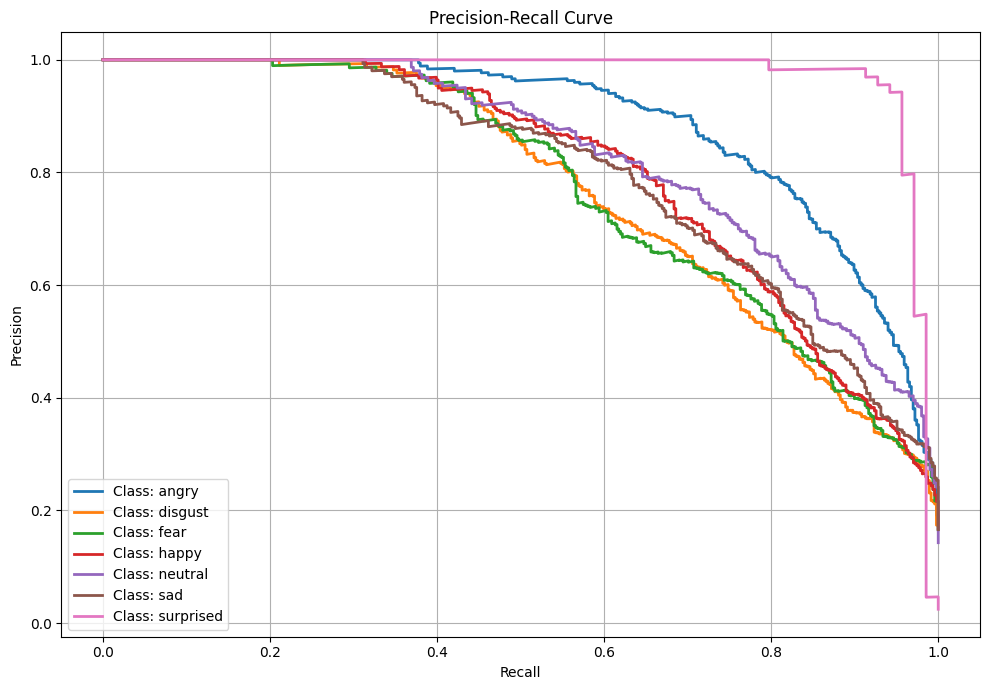

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class: {class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 17: Plot ROC Curves and Compute AUC for Each Emotion Class

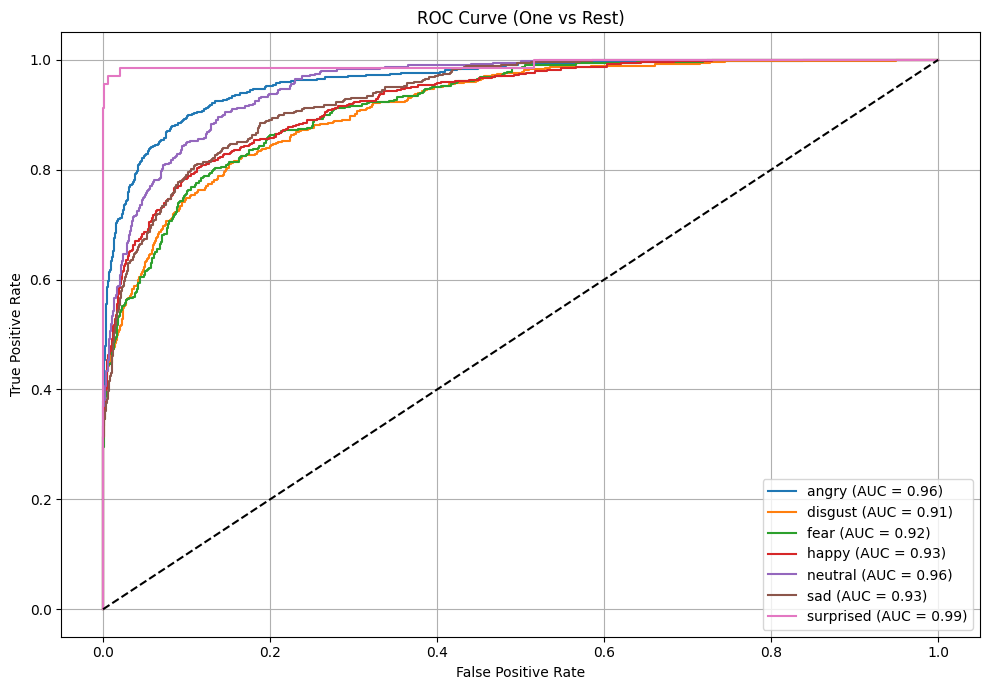

In [27]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One vs Rest)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 18: Compute and Plot Per-Class Accuracy

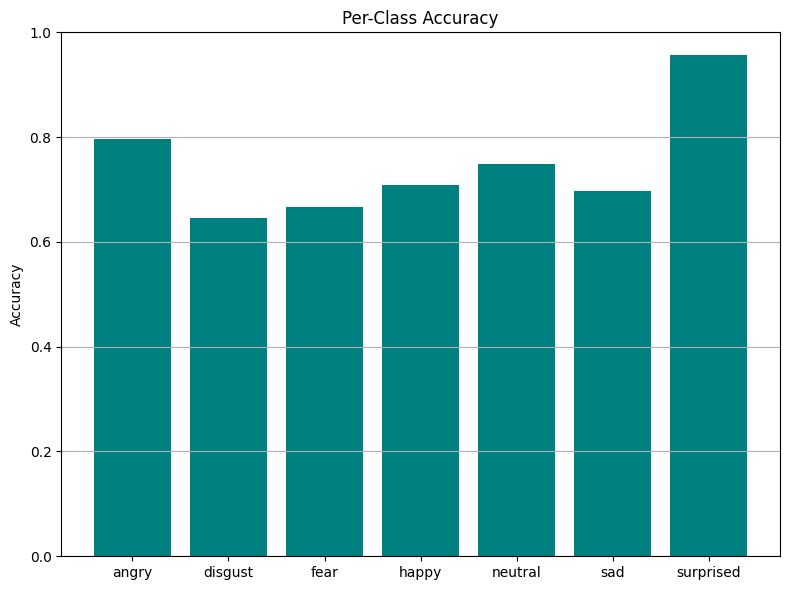

In [28]:
from sklearn.metrics import accuracy_score

# Per-class accuracy
per_class_acc = []
for i in range(len(class_names)):
    idxs = np.where(y_true == i)
    acc = accuracy_score(y_true[idxs], y_pred[idxs])
    per_class_acc.append(acc)

plt.figure(figsize=(8, 6))
plt.bar(class_names, per_class_acc, color='teal')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### Step 19: Define Function to Predict Emotion on Random Sample Images

In [29]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
from PIL import Image

def predict_on_sample_images(folder, model, class_names, img_size=(128, 128), count=5):
    results = []
    
    # Step 1: Randomly select sample images
    all_images = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for img_file in os.listdir(class_folder):
                if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                    all_images.append((os.path.join(class_folder, img_file), class_name))
    
    sampled_images = random.sample(all_images, min(count, len(all_images)))
    
    # Step 2: Predict and store results
    for img_path, actual_class in sampled_images:
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = tf.expand_dims(img_array, axis=0)
            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

            pred_probs = model.predict(img_array, verbose=0)
            predicted_index = np.argmax(pred_probs)
            predicted_class = class_names[predicted_index]
            confidence = float(np.max(pred_probs))

            results.append({
                "image_path": img_path,
                "actual": actual_class,
                "predicted": predicted_class,
                "confidence": confidence
            })

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    return results


### Step 20: Run Sample Image Prediction and Evaluate Accuracy

In [31]:
#  Run the function
results = predict_on_sample_images(
    folder="E:/final_dataset/val",
    model=model,
    class_names=class_names,
    img_size=img_size,
    count=5
)

#  Add correctness
for r in results:
    r["is_correct"] = r["actual"] == r["predicted"]

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Show results
print(df_results)

#  Accuracy summary
accuracy = df_results["is_correct"].mean() * 100
print(f"\nAccuracy on {len(df_results)} samples: {accuracy:.2f}%")



                                          image_path   actual predicted  \
0     E:/final_dataset/val\angry\1085_ITS_ANG_XX.png    angry     angry   
1   E:/final_dataset/val\disgust\1088_IEO_DIS_MD.png  disgust   disgust   
2  E:/final_dataset/val\disgust\03-01-07-01-02-02...  disgust   disgust   
3     E:/final_dataset/val\happy\1051_TSI_HAP_XX.png    happy   disgust   
4     E:/final_dataset/val\happy\1091_ITS_HAP_XX.png    happy     happy   

   confidence  is_correct  
0    0.981604        True  
1    0.719655        True  
2    0.931468        True  
3    0.494041       False  
4    0.284388        True  

Accuracy on 5 samples: 80.00%
